# Example on using pyXspec to fit a spectrum

It is a very simple example on using pyXspec. We'll use Kepler SNR observation with XMM-Newton.


In [1]:
import os
import xspec

from datetime import datetime

from astropy.io import fits
from astropy import units as u
from astropy.constants import b_wien

import pandas as pd

%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
sns.set(style="white")

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

In [2]:
home = os.path.expanduser('~')
#
wdir = f'{home}/Dropbox/Work/XMM/energy_scale_works'
spec_dir = f"{wdir}/Kepler/0084100101"
spec_file = f"{spec_dir}/pn_spectrum_grp0.fits"
#
# need to go to the spec dir to read the arf and rmf files
# first, store the current wd to get back to it at the end
#
current = os.getcwd()
os.chdir(spec_dir)

In [3]:
logfile = xspec.Xset.openLog(f"xspec.log")

try:
    s = xspec.Spectrum(spec_file)
except:
    print (f"Cannot read {spec_file} in XSPEC")
    raise Exception

## Plot the spectrum using XSPEC and matplotlib

In [4]:
#model = xspec.Model("po + ga")
model = xspec.Model("bbody + ga")
#
# initial parameters
#
ncomp = len(model.componentNames)
for icomp in model.componentNames:
    print (icomp,eval(f'model.{icomp}.parameterNames'))

bbody ['kT', 'norm']
gaussian ['LineE', 'Sigma', 'norm']


In [5]:
#
# the BlackBody peak at 6.5  keV 
#
# Wien's law, the temperature in kT units [keV] of a BB peaking at 6.5 keV
#
model.bbody.kT = 6.5/1.59362
# and fix it
model.bbody.kT.frozen = True
#
# initial sigma of the line is set to 50 eV, but can be between 1 and 100 eV
model.gaussian.Sigma = [5.0e-2,0.001,1.0e-3,1.0e-3,1.0e-1,1.0e-1]
#
line_c = 6.4 # keV
# set the initial line energy and the range where to lok for a C-stat minimum
model.gaussian.LineE = [line_c,0.001,line_c-0.2,line_c-0.1,line_c+0.1,line_c+0.2]

In [6]:
#
# the fitting cell
#
xspec.Fit.statMethod = "cstat"
xspec.Xset.abund = "wilm"
#
#
# will constrain the spectrum in [4.5-8] keV
#
startE = 4.5 # keV
endE = 8.0 # keV
#
s.notice("all")
s.ignore(f"**-{startE} {endE}-**")
#

In [7]:
model.show()

In [8]:
xspec.Fit.nIterations = 100
xspec.Fit.query = 'yes'
xspec.Fit.perform()
xspec.Fit.show()
cstat = xspec.Fit.statistic
dof = xspec.Fit.dof
chi2r = xspec.Fit.testStatistic/dof
#xspec.Fit.error("2.706 3 6")

## Print the fit results

The XSPEC output is stored in the log file but also in the stdout/stderr (notebok terminal). But there are methods to get them out of the Fit class.


## Plotting the data and the model with XSPEC


In [9]:
# plot in Xserver
xspec.Plot.device = '/xs'
# or save to postScript
#xspec.Plot.device = f'{psfile}/cps'
xspec.Plot.xAxis = "keV"
xspec.Plot.setRebin(minSig=30.0,maxBins=4)
xspec.Plot.addCommand("csize 1.2")
xspec.Plot.addCommand("lwidth 4")
xspec.Plot.addCommand("lab top \"Test plot\"")
xspec.Plot('ld','ratio') 

In [10]:
# reset the plot
xspec.Plot.commands = ()

Plot command list is now empty


## Plotting the data and the model with matplotlib

The idea on how to plot the model components is from the XSPEC facebook group, idea from Andy Beardmore. Saving in QDP file.


In [11]:
save_data = 'specfit.qdp'
if (os.path.isfile(save_data)):
    os.remove(save_data)
# following Andy Beardmore idea
xspec.Plot.device = '/null'
xspec.Plot.add = True
xspec.Plot.addCommand(f'wd {save_data}')
xspec.Plot("ld") 
#

In [12]:
#
names = ['e','de','rate','rate_err','total']
for j in range(ncomp):
    names.append(f'model{j}')
#print (names)
df = pd.read_table('specfit.qdp',skiprows=3,names=names, delimiter=' ')
df

,e,de,rate,rate_err,total,model0,model1
0,4.5100,0.0100,0.018456,0.006395,0.004903,0.004756,0.000147
1,4.5300,0.0100,0.011073,0.005222,0.004947,0.004762,0.000185
2,4.5500,0.0100,0.016611,0.006123,0.004996,0.004768,0.000228
3,4.5700,0.0100,0.014767,0.005221,0.005049,0.004775,0.000274
4,4.5900,0.0100,0.007383,0.003692,0.005100,0.004782,0.000318
5,4.6100,0.0100,0.009229,0.004127,0.005146,0.004789,0.000357
6,4.6300,0.0100,0.011073,0.005222,0.005183,0.004797,0.000385
7,4.6500,0.0100,0.005535,0.004129,0.005206,0.004806,0.000400
8,4.6700,0.0100,0.003692,0.002610,0.005214,0.004814,0.000399
9,4.6900,0.0100,0.016613,0.005538,0.005206,0.004823,0.000383


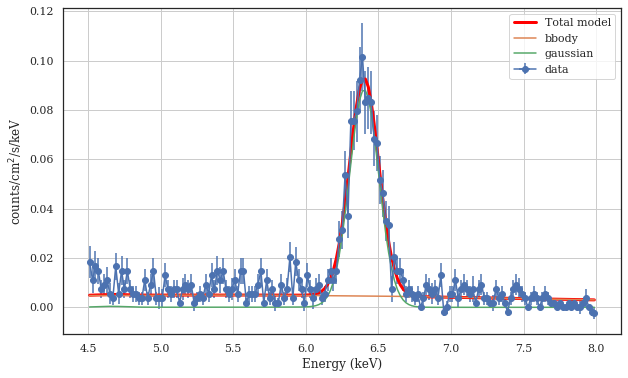

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
# # Plot using Matplotlib:
ax.errorbar(df.e, df.rate, xerr=df.de,yerr=df.rate_err,fmt='o-',label='data')
ax.plot(df.e, df.total, color='red',label='Total model',linewidth=3)
for j in range(ncomp):
    ax.plot(df.e, df[f'model{j}'],label=f'{model.componentNames[j]}')
#ax.plot(x, y)
ax.set_xlabel('Energy (keV)')
ax.set_ylabel(r'counts/cm$^2$/s/keV')
ax.set_xscale("linear")
ax.set_yscale("linear")
ax.grid()
ax.legend()
plt.show();
#

In [16]:
#
# clear all, data, plot commands and close the logfile
#
s = None
xspec.Plot.commands = ()
xspec.AllData.clear()
xspec.Xset.closeLog()

Plot command list is now empty
